# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/CI/"
!pip install import-ipynb

/content/drive/.shortcut-targets-by-id/1fPndHe31Mko5g75JKSEcrswLjQvUYExS/CI
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=888e2d5aebac7daab8c30c4fd3dc702ff51eae9f71b82c0b9e95b98eac70f005
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import import_ipynb
import utility
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

importing Jupyter notebook from utility.ipynb
Tensorflow Version: 2.4.1
GPU:  /device:GPU:0


# Preprocessing

## Dataset Loading

In the training set loading, the main important things are:
- filter out the baselines from labels and from images
- change the label 1 and 3 in 0
- change the label 2 and 4 in 1

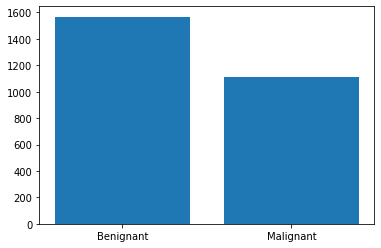

In [ ]:
images, labels = utility.load_training()

train_abnormal_images, train_abnormal_labels = utility.benignant_malignant_training_set_building(images, labels)

class_0 = len([labels for label in train_abnormal_labels if label == 0])
class_1 = len([labels for label in train_abnormal_labels if label == 1])

plt.bar(['Benignant', 'Malignant'], [class_0, class_1])
plt.title = 'Class Balancing after oversampling'
plt.show()

The classes are unbalaced: we can try to oversample the largest one.

1568
Oversampling must be done on 460 elements of the second array.
Class 0: 1568
Class 1: 1568


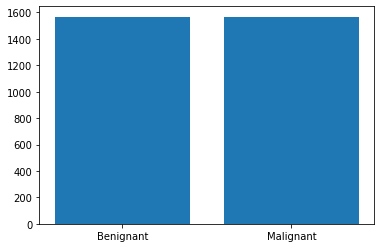

In [ ]:
train_abnormal_images, train_abnormal_labels = utility.oversample(train_abnormal_images, train_abnormal_labels)




class_0 = len([labels for label in train_abnormal_labels if label == 0])
class_1 = len([labels for label in train_abnormal_labels if label == 1])

plt.bar(['Benignant', 'Malignant'], [class_0, class_1])
plt.title = 'Class Balancing after oversampling'
plt.show()

Let's build now the test set: 

In [ ]:
test_images, test_labels = utility.load_test()

test_abnormal_images, test_abnormal_labels = utility.benignant_malignant_test_set_building(test_images, test_labels)

## Images Preparation

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

NORMALIZATION_VALUE = 65536

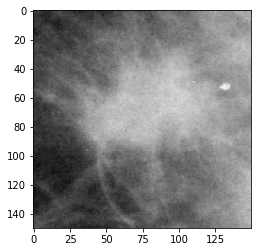

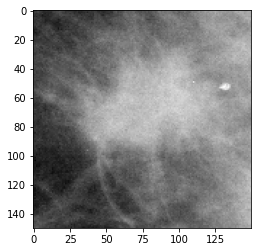

In [ ]:
#CONTRAST ADJUSTMENT
plt.imshow(train_abnormal_images[0], cmap='gray')
plt.show()

train_samples_adjusted = utility.apply_contrast(train_abnormal_images, contrast=1.5)

plt.imshow(train_samples_adjusted[0], cmap='gray')
plt.show()

test_samples_adjusted = utility.apply_contrast(test_abnormal_images, contrast=1.5)

### Generators

It's time to create the generators for training set, validation set (validation split 20%) and test set: in this phase we also normalize the images in [0,1] range

In [ ]:
train_samples_reshaped = np.expand_dims(train_samples_adjusted,3)

test_samples_reshaped = np.expand_dims(test_samples_adjusted,3)

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_samples_reshaped, train_abnormal_labels, test_size=val_split, stratify=train_abnormal_labels) #shuffle = True (default)

datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)

train_generator = datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE)
print('Train Generator created')
validation_generator = datagen.flow(X_val, 
                                     y=y_val, 
                                     batch_size=BATCH_SIZE)       
print('Validation Generator created')
           
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)


test_generator =  datagen.flow(test_samples_reshaped,
                                y=test_abnormal_labels,
                                batch_size=BATCH_SIZE)

print('Test Generator created')

Train Generator created
Validation Generator created
Test Generator created


## Network Building

Let's build the net

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.trainable = False
conv_base.summary()
print('VGG16 loaded and set untrainable')
#conv_base_4= Model(inputs=conv_base.input, outputs=conv_base.get_layer('block4_pool').output)
#conv_base_4.summary() # conv_base without classificator and top layer

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Training V1

In [ ]:
from tensorflow.keras import models, layers, regularizers

model_vgg16 = models.Sequential(name="v1")
model_vgg16.add(tf.keras.Input(shape=(150,150,1)))
model_vgg16.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) #paper 
model_vgg16.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree
model_vgg16.add(layers.Conv2D(3, (1, 1), activation='relu'))
model_vgg16.add(conv_base)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

model_vgg16.summary()

Model: "v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_7 (RandomFlip)   (None, 150, 150, 1)       0         
_________________________________________________________________
random_rotation_7 (RandomRot (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 3)       6         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513      

In [ ]:
opt = tf.keras.optimizers.Adam(0.003)

model_vgg16.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

EPOCHS = 20

In [ ]:
history = model_vgg16.fit(train_generator,
          validation_data=validation_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

In [ ]:
utility.plot_history(history, 'bm_vgg')

In [ ]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_vgg16.save(os.path.join(dir_name,'BM_VGG.h5'))

In [ ]:
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

normalized_test_samples_reshaped = test_samples_reshaped/NORMALIZATION_VALUE
test_predictions = model_vgg16.predict(normalized_test_samples_reshaped)

accuracy, confusion_matrix, auc, f2 = utility.do_evaluations(test_predictions, test_abnormal_labels)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

fig.savefig('/content/drive/MyDrive/CI/plot/final/bm_vgg_conf_matrix.png')